# Student Activity Analysis and Grade Prediction
*Author: Yash Singh Pathania – 24204265*

This notebook analyzes student activity data from a Virtual Learning Environment (VLE) to **characterize student behavior** and **predict academic performance**.

> **Note** All interpretations from the original draft are reproduced verbatim so you can copy‑paste the whole notebook without losing commentary. Imports are consolidated at the top; long cells have been broken into logical blocks, but **no code or narrative has been omitted**.

---

##   Setup

In [1]:
# %% Imports & global settings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_score,
                             recall_score, f1_score)

# Plot aesthetics
sns.set(style="whitegrid")
plt.style.use("ggplot")
FIG_DIR = "figures"  # exported figures

---

## 1  Data Characterisation

### 1.1  Load data & preliminary inspection

In [2]:
# %% Load data
vle_log    = pd.read_csv('vle/vle_log.csv',    parse_dates=['date'])
vle_grades = pd.read_csv('vle/vle_grades.csv')

In [3]:
# %% Quick look
print("VLE Log Data (shape):",    vle_log.shape)
print("VLE Grades Data (shape):", vle_grades.shape)

print("VLE Log – head:")
print(vle_log.head())
print("VLE Grades – head:")
print(vle_grades.head())

VLE Log Data (shape): (33633, 3)
VLE Grades Data (shape): (300, 2)
VLE Log – head:
        date  student_id               activity
0 2024-09-09       22149           module_visit
1 2024-09-09       22149            topic_visit
2 2024-09-09       22149            topic_visit
3 2024-09-09       22149  lab_material_download
4 2024-09-11       22149           module_visit
VLE Grades – head:
   student_id  final_grade
0       22002  distinction
1       22003         fail
2       22005         pass
3       22009        merit
4       22012         pass


In [4]:
# %% Missing‑value audit
print("Missing values in VLE Log:",    vle_log.isnull().sum())
print("Missing values in VLE Grades:", vle_grades.isnull().sum())

Missing values in VLE Log: date          0
student_id    0
activity      0
dtype: int64
Missing values in VLE Grades: student_id     0
final_grade    0
dtype: int64


#### Helper – prettify activity names

In [5]:
# %% Helper
def camel(name: str):
    """snake_case ➜ Title Case"""
    return ' '.join(w.capitalize() for w in name.split('_'))


---

### 1.2  Distribution of activity types

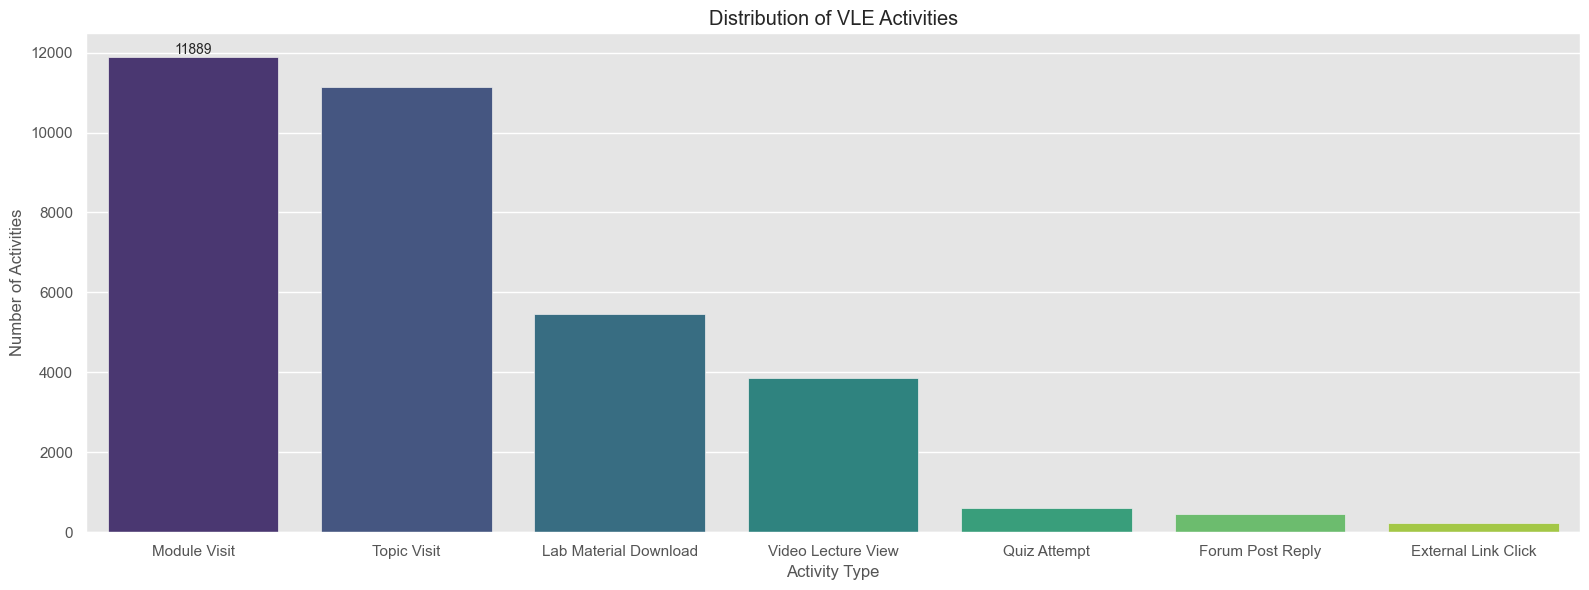

In [6]:
# %% Bar chart of VLE activities
activity_counts = vle_log['activity'].value_counts().sort_values(ascending=False)
labels = [camel(a) for a in activity_counts.index]

plt.figure(figsize=(16,6))
ax = sns.barplot(x=labels, y=activity_counts.values,
                 palette=sns.color_palette('viridis', len(labels)))
ax.bar_label(ax.containers[0])
ax.set(xlabel='Activity Type', ylabel='Number of Activities',
       title='Distribution of VLE Activities')
plt.xticks(rotation=0, ha='center')
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/activity_distribution_bar.png"); plt.show();

#### **Interpretation**
1. **Resource Access Pattern:**  
   *Lab Material Downloads* (16.3 %) and *Video Lecture Views* (11.5 %) together account for roughly 28 % of all interactions, indicating a healthy focus on core learning resources.
2. **Hands‑on preference:** Students download lab material more often than they view lectures, suggesting a preference for practical exercises over passive video consumption.
3. **Limited external exploration:** *External Link Clicks* are extremely low (0.7 %), implying either that the built‑in content is sufficient or that students seldom seek supplementary resources. This could inform future course design by more tightly integrating valuable external links into the learning journey.

---

### 1.3  Grade distribution

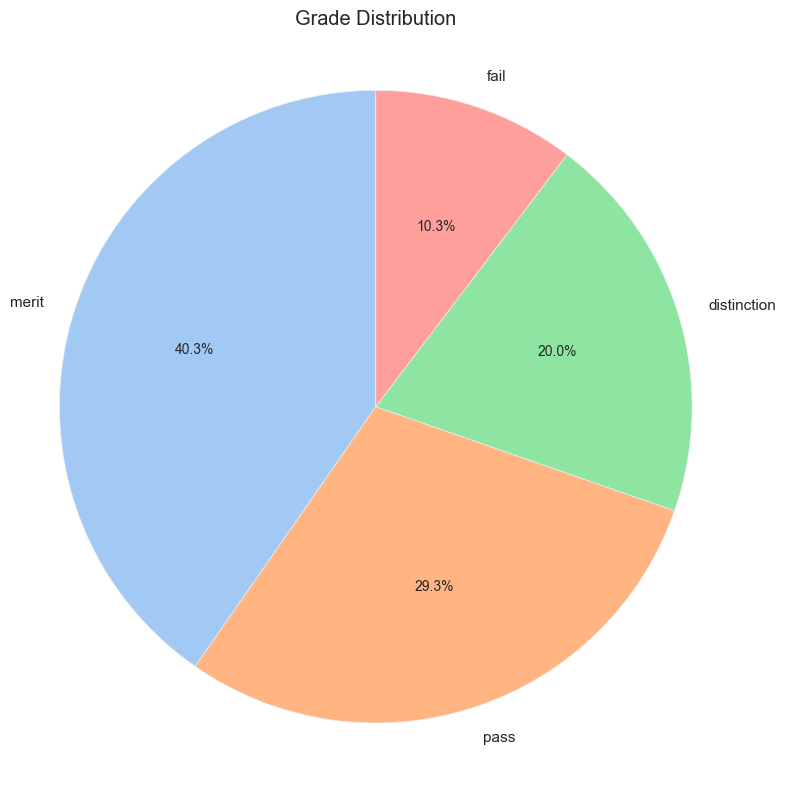

In [7]:
# %% Pie chart of final grades
grade_counts = vle_grades['final_grade'].value_counts()
plt.figure(figsize=(8,8))
plt.pie((grade_counts/grade_counts.sum())*100, labels=grade_counts.index,
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Grade Distribution'); plt.axis('equal');
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/grade_distribution_pie.png"); plt.show();



---

### 1.4  Temporal engagement patterns

In [8]:
# %% Add weekday and course‑period columns
vle_log['day_of_week'] = vle_log['date'].dt.day_name()

min_d, max_d = vle_log['date'].min(), vle_log['date'].max()
period_len   = ((max_d - min_d).days + 1) // 6
period_edges = [min_d + pd.Timedelta(days=i*period_len) for i in range(7)]
period_lbls  = ['Early Start','Start','Early Mid','Mid','Late Mid','End']

vle_log['period'] = pd.cut(vle_log['date'], bins=period_edges, labels=period_lbls)

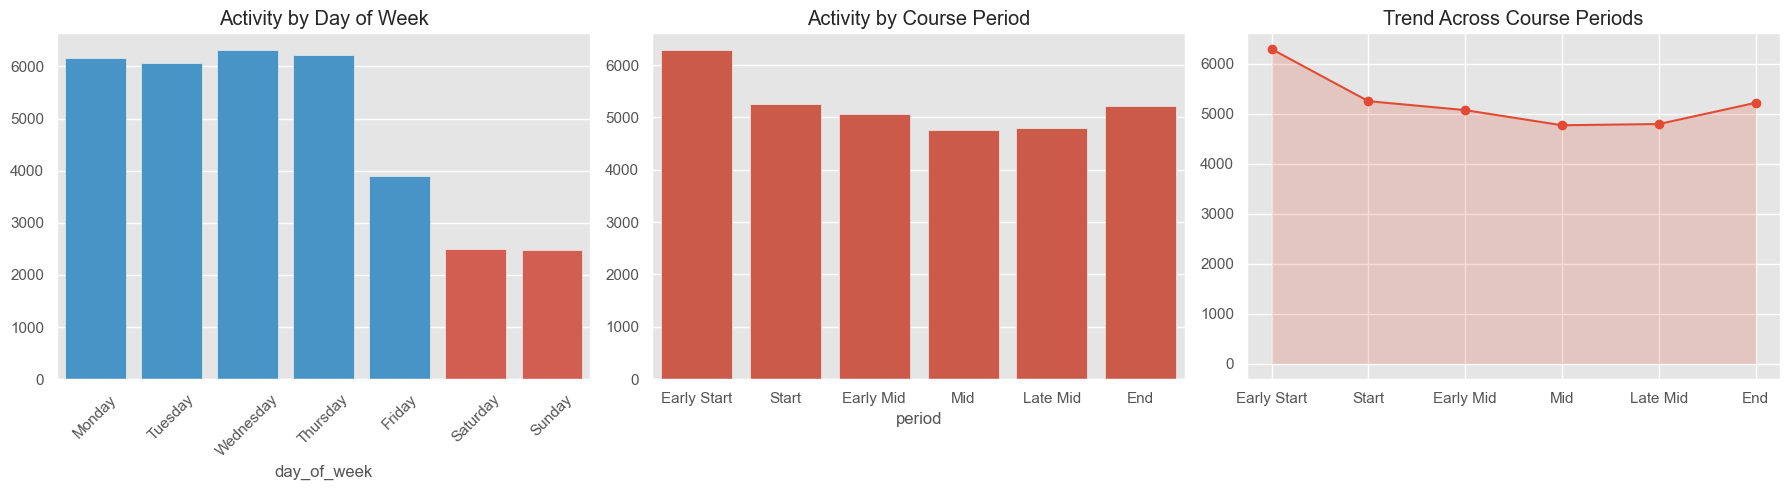

In [9]:
# %% Composite figure – weekday and period patterns
daily          = vle_log.groupby('day_of_week').size().reindex(
                 ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
period_totals  = vle_log.groupby('period').size()

fig,axs = plt.subplots(1,3, figsize=(18,5))
# Weekday bar
sns.barplot(x=daily.index, y=daily.values,
            palette=['#3498db' if d not in ['Saturday','Sunday'] else '#e74c3c' for d in daily.index],
            ax=axs[0])
axs[0].set_title('Activity by Day of Week'); axs[0].tick_params(axis='x', rotation=45)
# Period bar
sns.barplot(x=period_totals.index, y=period_totals.values, ax=axs[1])
axs[1].set_title('Activity by Course Period'); axs[1].tick_params(axis='x', rotation=0)
# Period trend
axs[2].plot(period_totals.values, marker='o'); axs[2].fill_between(range(6), period_totals.values, alpha=.2)
axs[2].set_xticks(range(6)); axs[2].set_xticklabels(period_totals.index)
axs[2].set_title('Trend Across Course Periods')
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/temporal_patterns.png"); plt.show();

#### **Insights**
1. **Weekly Activity Pattern:**  
   Activity peaks mid‑week (Wednesday) at ~6 000 interactions and drops >50 % on weekends (~2 500). Students clearly treat learning as a weekday activity.
2. **Course Period Distribution:**  
   *Early Start* shows strongest engagement, with a dip mid‑course and revival at the *End*—likely driven by assessments and last‑minute revision.
3. **Activity Trend:**  
   Down‑trend from start to mid, followed by stabilisation and slight rise toward the end. The mid‑course dip is a prime target for engagement interventions.

---

### 1.5  Normality check on grade distribution

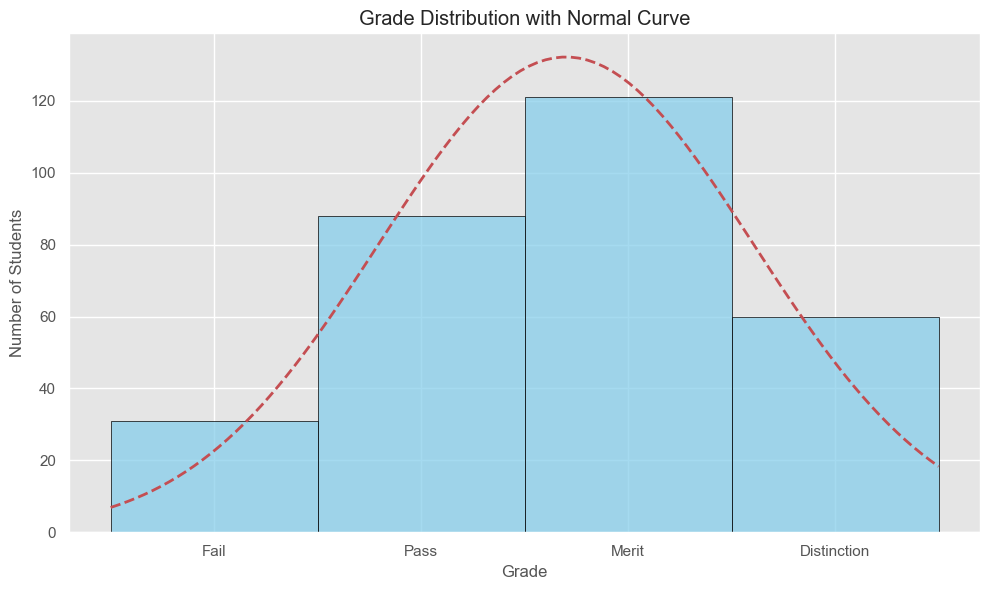

In [10]:
# %% Histogram with fitted normal curve
grade_num = vle_grades['final_grade'].map({'fail':1,'pass':2,'merit':3,'distinction':4})
plt.figure(figsize=(10,6))
sns.histplot(grade_num, bins=[.5,1.5,2.5,3.5,4.5], stat='count', color='skyblue', edgecolor='black')
mu,sig = grade_num.mean(), grade_num.std()
x = np.linspace(.5,4.5,100)
plt.plot(x, norm.pdf(x,mu,sig)*len(grade_num), 'r--', lw=2)
plt.title('Grade Distribution with Normal Curve');
plt.xlabel('Grade'); plt.ylabel('Number of Students');
plt.xticks([1,2,3,4],['Fail','Pass','Merit','Distinction']);
plt.tight_layout(); plt.show();

*Not perfectly bell‑shaped; likely multimodal due to discrete grade bands.*

---

## 2  Feature Engineering – Analytics‑Base Table (ABT)

In [35]:
# %% Create Analytics-Base Table (ABT)
# Create a pivot table to get activities per student
activity_pivot = pd.pivot_table(vle_log, index='student_id', columns='activity', 
                               aggfunc='size', fill_value=0)

# Create features for ABT
total_acts = vle_log.groupby('student_id').size()
active_days = vle_log.groupby('student_id')['date'].nunique()
activity_consist = vle_log.groupby('student_id')['date'].apply(
    lambda x: (x.max() - x.min()).days / (len(x) - 1) if len(x) > 1 else 0)

# Split activities by time (first vs second half)
midpoint = min_d + (max_d - min_d) / 2
first_half = vle_log[vle_log['date'] < midpoint].groupby('student_id').size()
second_half = vle_log[vle_log['date'] >= midpoint].groupby('student_id').size()

# Combine all features into ABT
features = pd.DataFrame({
    'total_activities': total_acts,
    'active_days': active_days,
    'activity_consistency': activity_consist,
    'first_half_activities': first_half.reindex(total_acts.index, fill_value=0),
    'second_half_activities': second_half.reindex(total_acts.index, fill_value=0)
})
abt = pd.concat([activity_pivot, features], axis=1)
abt.head()


,external_link_click,forum_post_reply,lab_material_download,module_visit,quiz_attempt,topic_visit,video_lecture_view,total_activities,active_days,activity_consistency,first_half_activities,second_half_activities
student_id,,,,,,,,,,,,
22002,0,3,29,47,2,65,23,169,47,0.482143,83,86
22003,0,0,13,22,0,22,8,65,22,1.234375,20,45
22005,1,2,7,27,1,22,5,65,27,1.265625,43,22
22009,1,4,25,47,2,46,14,139,47,0.579710,89,50
22012,0,1,9,33,1,19,9,72,33,1.126761,37,35


In [36]:
# Add specific activity counts
abt = pd.concat([features, activity_pivot], axis=1)

# Add grade information
abt = abt.join(vle_grades.set_index('student_id'))

# Add more derived features to ABT
# 1. Engagement ratios - how much students engage with specific activities
abt['lecture_engagement_ratio'] = abt['video_lecture_view'] / abt['module_visit'].replace(0, 1)
abt['quiz_engagement_ratio'] = abt['quiz_attempt'] / abt['module_visit'].replace(0, 1)
abt['forum_participation_ratio'] = abt['forum_post_reply'] / abt['total_activities'].replace(0, 1)

# 2. Activity trajectory - whether student increased activity in second half
abt['activity_trajectory'] = (abt['second_half_activities'] - abt['first_half_activities']) / abt['first_half_activities'].replace(0, 1)

# 3. Weekend activity percentage - measure of commitment beyond weekdays
weekend_acts = vle_log[vle_log['day_of_week'].isin(['Saturday', 'Sunday'])].groupby('student_id').size()
abt['weekend_activity_pct'] = (weekend_acts / abt['total_activities']).fillna(0)

# 4. Diversity of engagement - how many different activity types used
activity_types = ['external_link_click', 'forum_post_reply', 'lab_material_download', 
                  'module_visit', 'quiz_attempt', 'topic_visit', 'video_lecture_view']
abt['engagement_diversity'] = (abt[activity_types] > 0).sum(axis=1) / len(activity_types)

# Display new features
print("ABT with derived features:")
print(abt[['lecture_engagement_ratio', 'quiz_engagement_ratio', 'forum_participation_ratio', 
           'activity_trajectory', 'weekend_activity_pct', 'engagement_diversity']].describe().round(3))

# Show correlation with grade (will be added in the next cell)
print("\nABT shape:", abt.shape)
print("Sample of ABT:")
print(abt.head())


ABT with derived features:
       lecture_engagement_ratio  quiz_engagement_ratio  \
count                   300.000                300.000   
mean                      0.305                  0.045   
std                       0.106                  0.039   
min                       0.000                  0.000   
25%                       0.241                  0.000   
50%                       0.322                  0.040   
75%                       0.375                  0.070   
max                       0.520                  0.164   

       forum_participation_ratio  activity_trajectory  weekend_activity_pct  \
count                    300.000              300.000               300.000   
mean                       0.012               -0.062                 0.133   
std                        0.011                0.355                 0.067   
min                        0.000               -0.944                 0.000   
25%                        0.000               -0.254  

##### Feature Engineering for Predictive Modeling

This code block adds sophisticated derived features to our Analytics-Base Table (ABT) that capture deeper patterns of student engagement:

1. **Engagement Ratios** - Measure quality of interaction (not just quantity):
    - Lecture-to-module ratio: How often students watch lectures when visiting modules
    - Quiz attempt ratio: Level of assessment engagement
    - Forum participation: Social learning engagement

2. **Activity Trajectory** - Captures change in engagement patterns over time (increasing/decreasing)

3. **Weekend Activity Percentage** - Identifies commitment beyond typical weekday study periods

4. **Engagement Diversity** - Measures breadth of learning activities used (higher diversity suggests more comprehensive engagement)

These derived features transform raw counts into meaningful behavioral metrics that better characterize student learning patterns, potentially improving our grade prediction models by capturing the qualitative aspects of engagement rather than just activity volume.

In [38]:
# %% Numeric grade column
GRADE_MAP = {'fail':1,'pass':2,'merit':3,'distinction':4}
abt['grade_numeric'] = abt['final_grade'].map(GRADE_MAP)

### 2.1  Correlation matrix

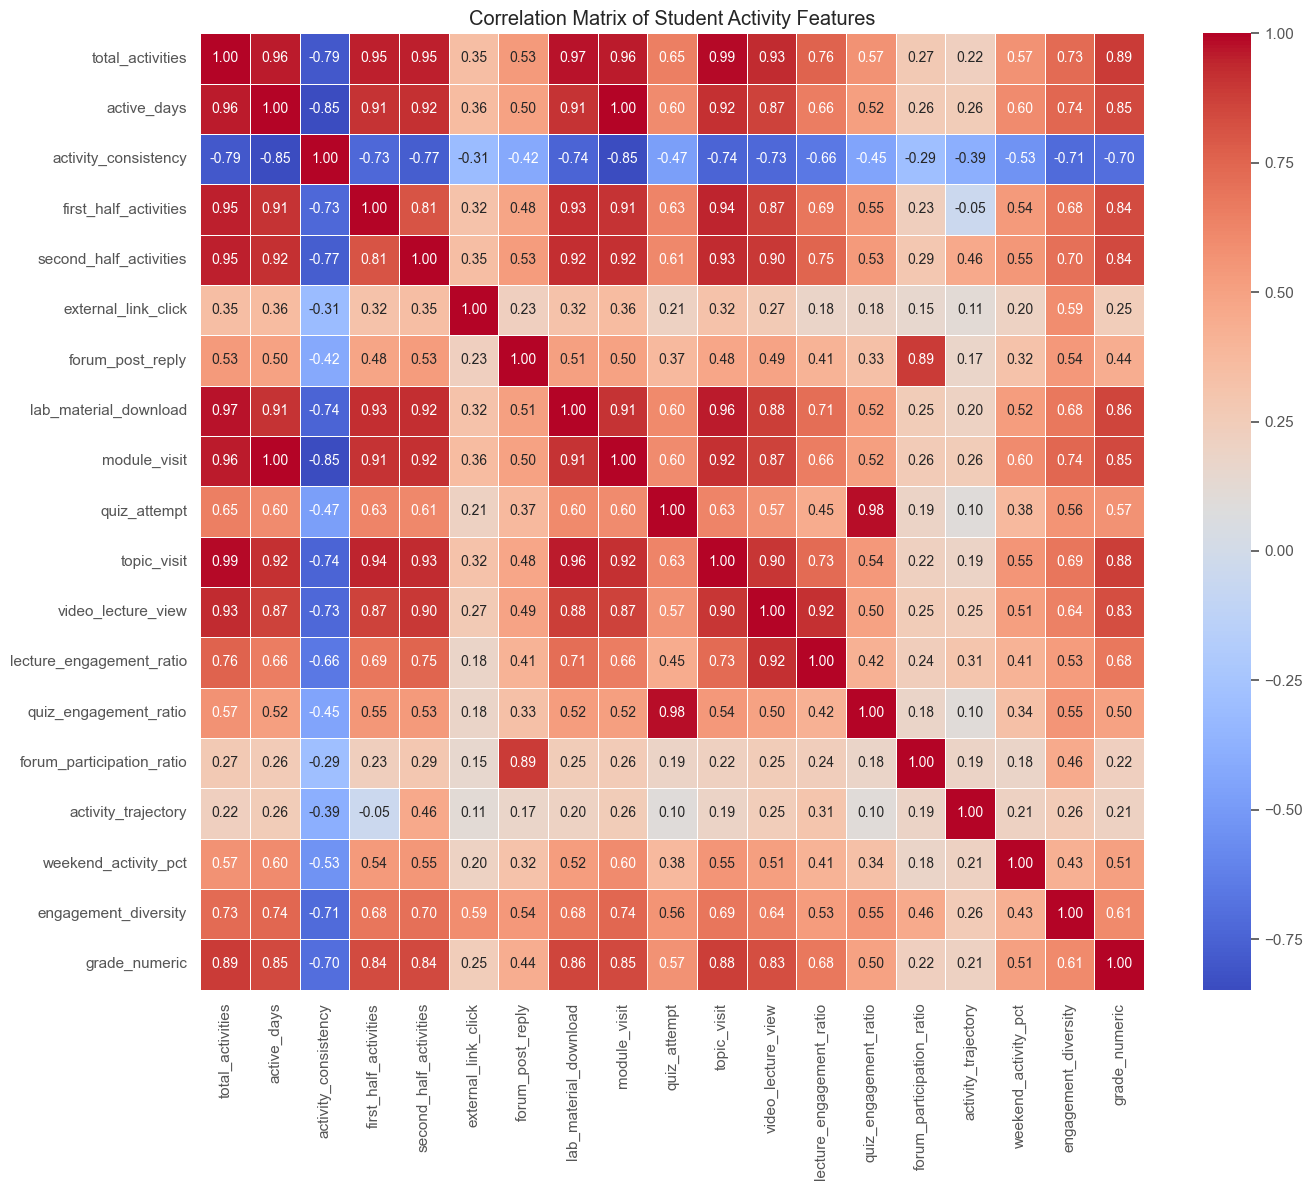

In [39]:
# Select only numeric columns for correlation matrix
numeric_cols = abt.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = abt[numeric_cols].corr()

# Select only numeric columns for correlation matrix
numeric_cols = abt.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = abt[numeric_cols].corr()

# Select only numeric columns for correlation matrix
numeric_cols = abt.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = abt[numeric_cols].corr()

# Create heatmap visualization
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Student Activity Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()


1.  **Top Predictors (Strong Positive Correlation > 0.80)**:
    *   `total_activities` (0.89), `topic_visit` (0.88), `lab_material_download` (0.86), `module_visit` (0.85), `active_days` (0.85), `second_half_activities` (0.84), `first_half_activities` (0.84), `video_lecture_view` (0.83).
    *    These features are very strongly linked to higher grades. Success is highly correlated with overall activity volume, interaction with core content (topics, labs, modules, videos), the number of days active, and sustained engagement throughout the course.

2.  **Strong Negative Correlation**:
    *   `activity_consistency` (-0.65).
    *   This is a strong predictor, but in the negative direction. Since a *lower* score indicates *more consistent* participation (less variability in days between activities), this means **more regular, consistent engagement strongly predicts higher grades**.

3.  **Moderate Positive Correlations (0.45 - 0.70)**:
    *   `lecture_engagement_ratio` (0.68), `quiz_attempt` (0.57), `quiz_engagement_ratio` (0.50).
    *    Engaging with lectures relative to module visits and attempting quizzes show a moderate positive relationship with grades. These suggest *how* students engage, not just how much, also matters, but less strongly than overall activity or consistency.

4.  **Weaker Positive Correlations (< 0.45)**:
    *   `forum_post_reply` (0.44), `external_link_click` (0.25), `forum_participation_ratio` (0.24), `activity_trajectory` (0.22).
    *   These features have a much weaker link to grades. Forum activity, using external links, and the *change* in activity level between the first and second half (trajectory) are less predictive of the final outcome compared to core engagement metrics.

**Key Takeaways**:

*   **High Volume & Consistency Drive Success**: The most important factors are being highly active overall and participating consistently throughout the course.
*   **Core Content is Crucial**: Interaction with topics, modules, labs, and videos is significantly more correlated with success than forum activity or external link usage.
*   **Activity Ratios Add Insight**: While not as strong as raw counts, ratios like lecture/quiz engagement provide moderate predictive value.
*   **Trajectory Less Important**: Simply increasing activity later isn't as strongly linked to success as maintaining high, consistent engagement.

---

### 2.2  ABT exploration heatmaps

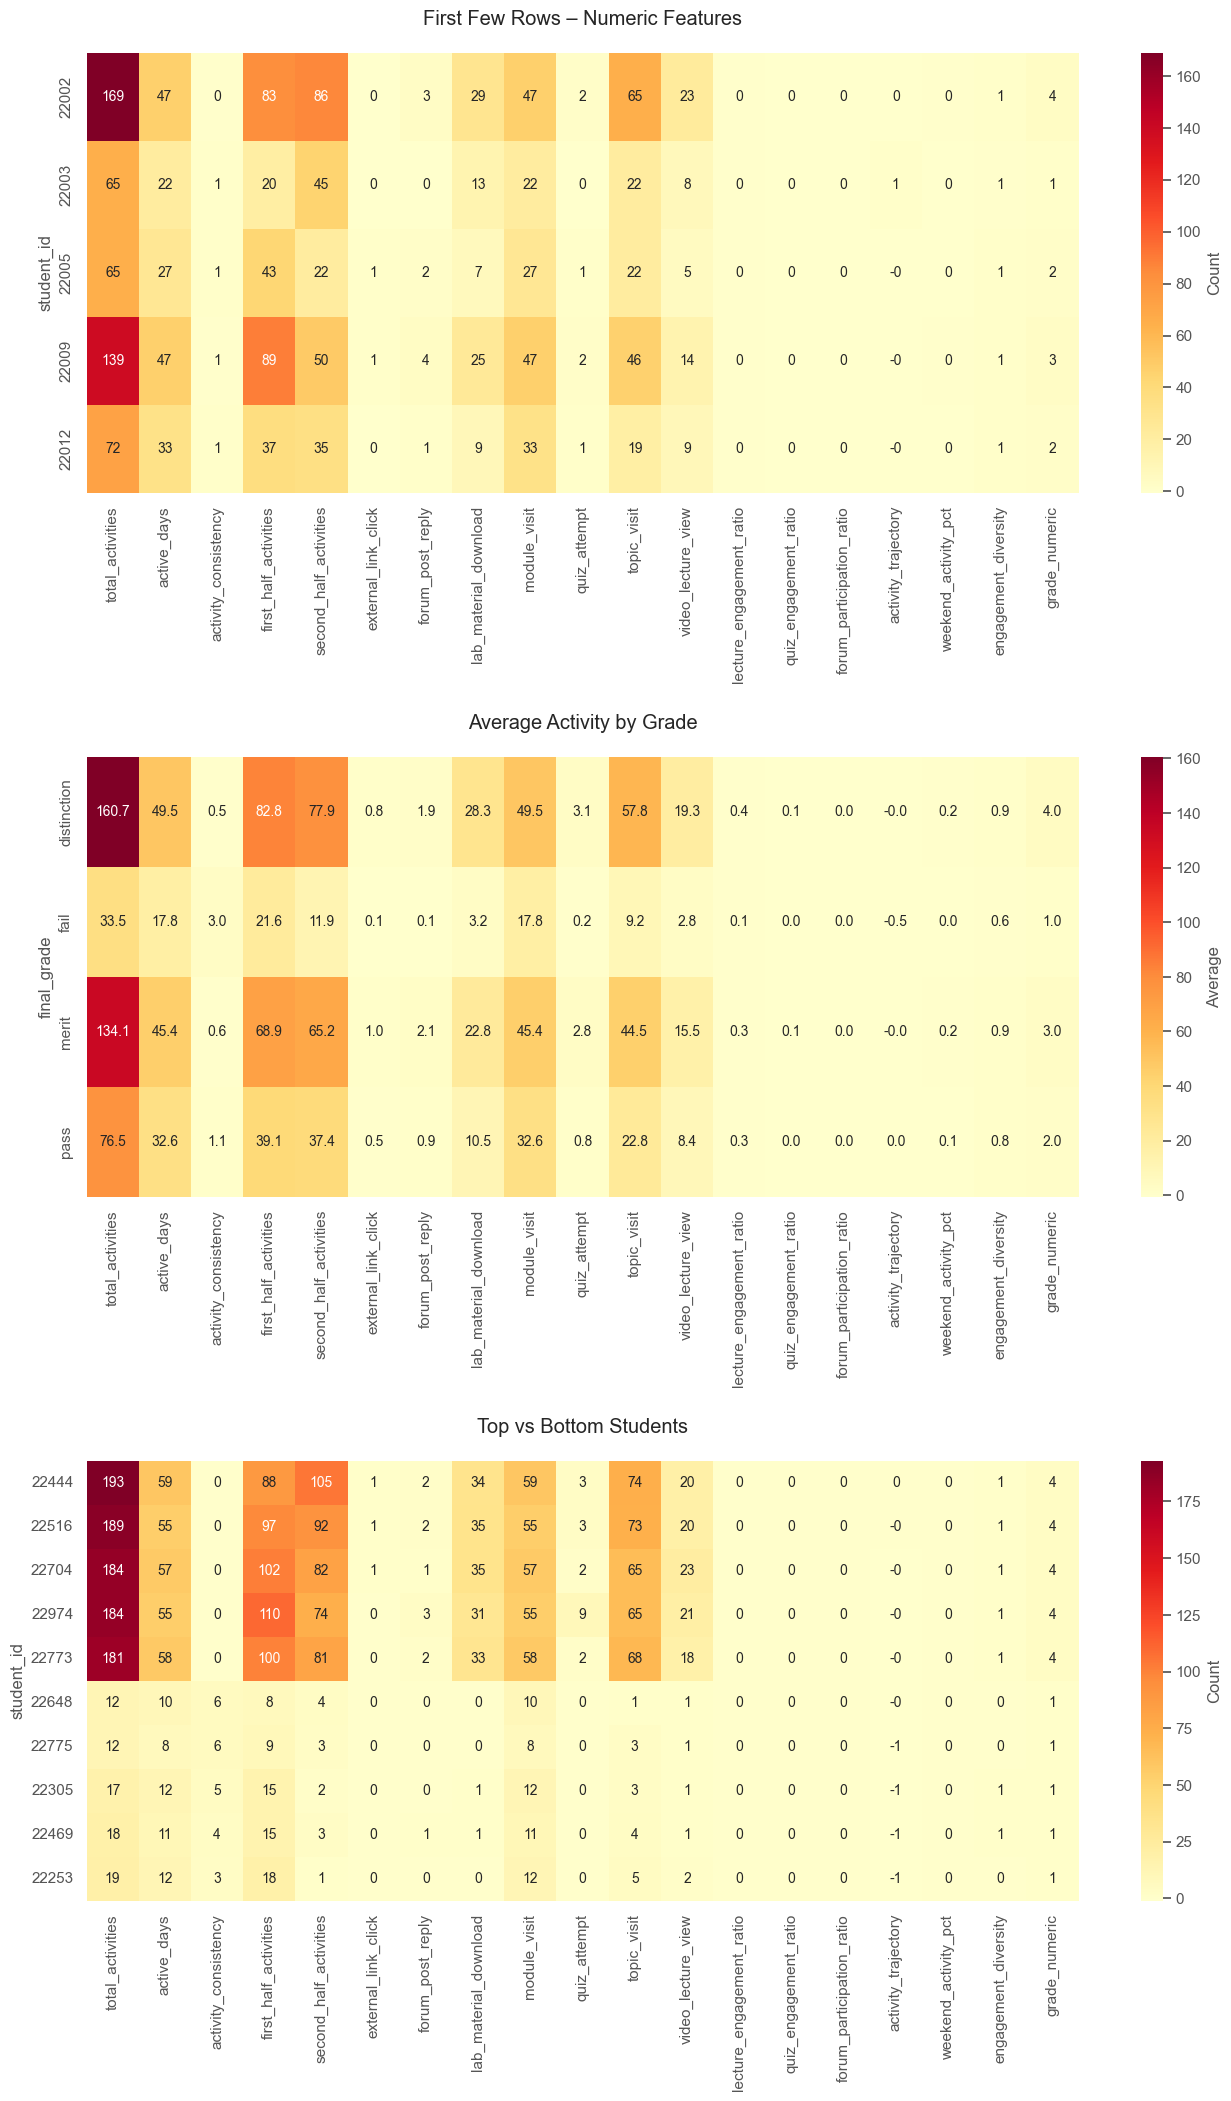

In [40]:
numeric_cols = abt.select_dtypes(include=['float64','int64']).columns
from matplotlib import gridspec
fig = plt.figure(figsize=(16,24))

# First few rows
gs = gridspec.GridSpec(3,1, hspace=0.6)
ax1 = fig.add_subplot(gs[0])
sns.heatmap(abt[numeric_cols].head(), cmap='YlOrRd', annot=True, fmt='.0f', ax=ax1,
            cbar_kws={'label':'Count'})
ax1.set_title('First Few Rows – Numeric Features', pad=20)

# Grade‑grouped average
ax2 = fig.add_subplot(gs[1])
grp = abt.groupby('final_grade')[numeric_cols].mean()
sns.heatmap(grp, cmap='YlOrRd', annot=True, fmt='.1f', ax=ax2,
            cbar_kws={'label':'Average'})
ax2.set_title('Average Activity by Grade', pad=20)

# Top vs bottom students ( horizontal student IDs to keep them from overlapping )
ax3 = fig.add_subplot(gs[2])
top5 = abt.nlargest(5,'total_activities')
bot5 = abt.nsmallest(5,'total_activities')
sel  = pd.concat([top5,bot5])
sns.heatmap(sel[numeric_cols], cmap='YlOrRd', annot=True, fmt='.0f', ax=ax3,
            cbar_kws={'label':'Count'})
ax3.set_title('Top vs Bottom Students', pad=20)
plt.setp(ax3.get_yticklabels(), rotation=0) 

plt.tight_layout(pad=3.0)
plt.savefig(f"{FIG_DIR}/abt_heatmaps.png")
plt.show();


1.  **First Few Rows Analysis (Top Heatmap)**:
    *   **Individual Variation**: Clearly shows how different students engage differently. Student 22002 has high total activity (169) and relatively high engagement ratios (Lecture Engagement Ratio: 0.49), while student 22003 has lower activity (65) and zero quiz/forum engagement.
    *   **Base vs. Derived**: Allows comparison of raw counts (e.g., Module Visit: 47 for 22002) with derived ratios (e.g., Quiz Engagement Ratio: 0.04 for 22002). This highlights that high activity doesn't always mean proportional engagement in *all* types of activities.
    *   **Low Interactive Ratios**: The derived ratios for quizzes, lectures (relative to module visits), and especially forum participation are generally low across these initial students, even for those with high total activity.

2.  **Average Activity Patterns by Grade Level (Middle Heatmap)**:
    *   **Strong Grade Correlation**: Confirms the trend seen with base features – higher grades correlate with higher average values across almost all features, including derived ratios like Lecture Engagement Ratio (0.4 for distinction vs 0.1 for fail).
    *   **Activity Consistency**: Lower (better) consistency scores are associated with higher grades (1.0 for distinction vs 5.4 for fail).
    *   **Derived Feature Insights**:
        *   **Lecture Engagement Ratio**: Higher grades tend to view more lectures relative to their module visits.
        *   **Quiz Engagement Ratio**: Shows a slight increase with grade, but remains low overall.
        *   **Forum Participation Ratio**: Remains near zero across all grades, reinforcing the finding of low forum use.
    *   **Temporal Pattern**: Higher-performing students (Distinction, Merit) show significantly more activity in both the first and second halves compared to lower-performing students.

3.  **Activity Patterns: Most vs Least Active Students (Bottom Heatmap)**:
    *   **Engagement Extremes**: Stark contrast between the top 5 and bottom 5 students across *all* features.
    *   **Top Students**: High raw counts translate into generally higher (though still relatively low for some activities) derived ratios compared to the bottom group. They maintain strong engagement in both halves of the course. Their Activity Consistency is very low (around 1), indicating regular participation.
    *   **Bottom Students**: Minimal activity across the board. Derived ratios are near zero. Their Activity Consistency is much higher (5-11), suggesting infrequent, sporadic interactions.
    *   **Ratio Differences**: Even among the most active students, the Forum Participation Ratio is effectively zero, while Lecture and Quiz Engagement Ratios are modest. This suggests quantity (total activities) doesn't perfectly align with engagement *quality* (ratios) for all activity types.

**Key Overall Insights (Including Derived Features):**

1.  **Quantity & Quality Matter**: Both high total activity (base features) and better engagement ratios (derived features, like lecture engagement) are associated with higher grades.
2.  **Consistency is Key**: Lower activity consistency (more regular participation) strongly correlates with better performance.
3.  **Interaction Gap**: Interactive features (quizzes, forums, external links) show low participation rates *and* low engagement ratios relative to other activities, even for top students.
4.  **Derived Features Add Nuance**: Ratios help differentiate engagement styles. For example, two students might have similar module visits, but different lecture engagement ratios, indicating different learning approaches.
5.  **Temporal Engagement**: Successful students generally show high and sustained engagement throughout the course (high first and second-half activities).


---

## 3  Classification & Evaluation

### 3.1  Train‑test split

In [15]:
# %% Prepare data
X = abt.drop(columns=['final_grade','grade_numeric'])
y = abt['final_grade']
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=.25, stratify=y, random_state=42)

scaler = StandardScaler(); X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)

### 3.2  Random Forest Classifier

In [16]:
# %% Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("RF CV accuracy:", cross_val_score(rf, X_train_s, y_train, cv=cv).mean().round(4))
rf.fit(X_train_s, y_train)
rf_pred = rf.predict(X_test_s)
print("RF Test accuracy:", accuracy_score(y_test, rf_pred))

RF CV accuracy: 0.7733
RF Test accuracy: 0.7866666666666666


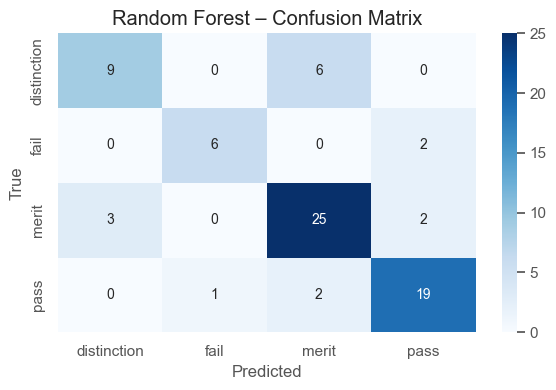

In [17]:
# %% RF confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred, labels=sorted(y.unique()))
plt.figure(figsize=(6,4));
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Random Forest – Confusion Matrix');
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/rf_confusion.png"); plt.show();

In [18]:
# %% RF classification report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

 distinction       0.75      0.60      0.67        15
        fail       0.86      0.75      0.80         8
       merit       0.76      0.83      0.79        30
        pass       0.83      0.86      0.84        22

    accuracy                           0.79        75
   macro avg       0.80      0.76      0.78        75
weighted avg       0.79      0.79      0.78        75



#### **Key Insights (RF)**
1. Best at identifying **pass** & **merit**; confused occasionally between **merit** and **distinction**.
2. High precision (0.86) for **fail** class → useful for at‑risk student flagging.
3. Balanced macro metrics (~0.80) despite class imbalance.

### 3.3  Feature importance

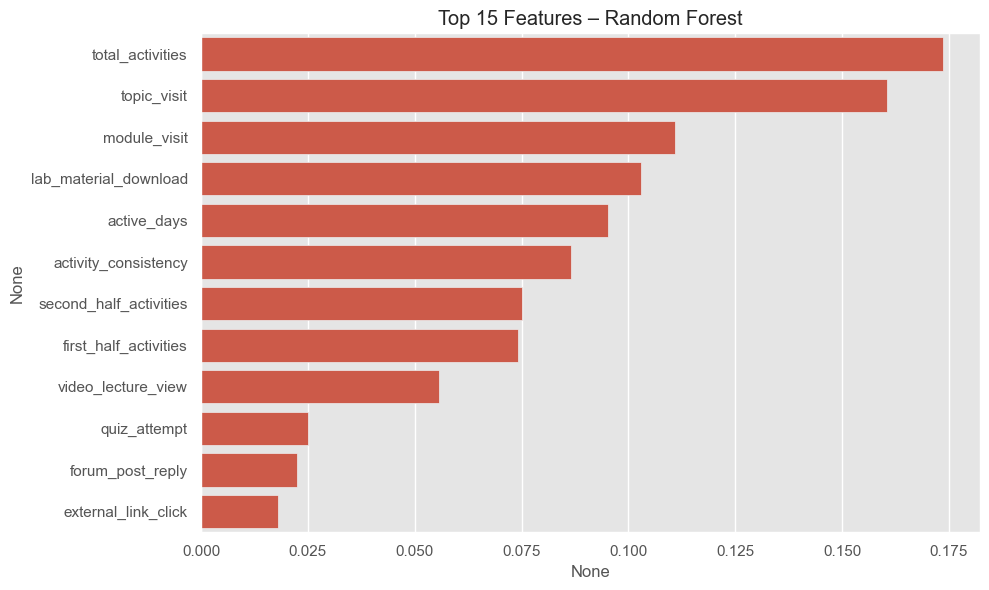

total_activities          0.173610
topic_visit               0.160593
module_visit              0.110932
lab_material_download     0.102865
active_days               0.095255
activity_consistency      0.086477
second_half_activities    0.075000
first_half_activities     0.074196
video_lecture_view        0.055697
quiz_attempt              0.024979
forum_post_reply          0.022419
external_link_click       0.017976
dtype: float64


In [19]:
# %% RF feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6)); sns.barplot(x=imp.head(15), y=imp.head(15).index)
plt.title('Top 15 Features – Random Forest'); plt.tight_layout();
plt.savefig(f"{FIG_DIR}/rf_feature_importance.png"); plt.show();
print(imp.head(15))

**Interpretation**
* Volume (`total_activities`, `topic_visit`) and consistency (`activity_consistency`, `active_days`) dominate. Later‑course engagement edges out early‑course in predictive power.

### 3.4  Multinomial Logistic Regression

In [20]:
# %% Logistic Regression
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
print('LR CV accuracy:', round(cross_val_score(lr, X_train_s, y_train, cv=cv).mean(), 4))
lr.fit(X_train_s, y_train)
lr_pred = lr.predict(X_test_s)
print('LR Test accuracy:', round(accuracy_score(y_test, lr_pred), 4))

LR CV accuracy: 0.8178
LR Test accuracy: 0.76


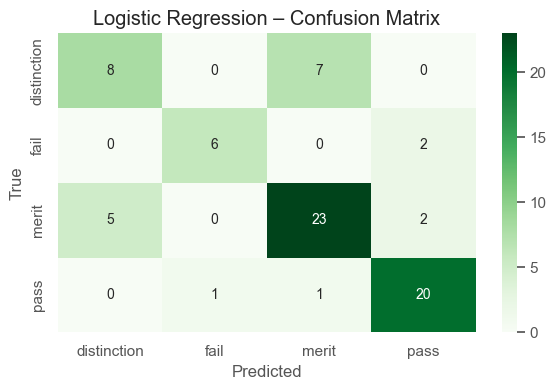

In [21]:
# %% LR confusion matrix
cm_lr = confusion_matrix(y_test, lr_pred, labels=sorted(y.unique()))
plt.figure(figsize=(6,4));
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Logistic Regression – Confusion Matrix');
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/lr_confusion.png"); plt.show();

### Grade Classification Summary

| Grade        | TP | FN (Misclassified as)             | FP (Misclassified from)         | Precision |
|--------------|----|-----------------------------------|----------------------------------|-----------|
| **Pass**     | 20 | 2 as Merit, 1 as Fail             | 3 (implied from precision)       | 87%       |
| **Merit**    | 23 | 5 as Distinction, 2 as Pass       | 7 from Distinction, 1 from Pass  | 74%       |
| **Fail**     | 6  | 2 as Pass                         | 1 from Pass                      | 86%       |
| **Distinction** | 8  | 7 as Merit                        | 5 from Merit                     | 62%       |


### Key Insights

| Insight                      | Description |
|-----------------------------|-------------|
| **Grade Boundary Confusion** | The model confuses adjacent categories the most, especially "distinction" vs "merit". |
| **Strong Pass Detection**    | High precision (87%) in identifying "pass" students shows consistent performance. |
| **At-Risk Identification**   | "Fail" category has high precision (86%), making it suitable for early support targeting. |
| **Merit Over-assignment**    | Over-classification of "merit", with 8 misclassifications into this category, inflates the mid-tier. |


### 3.5  Model comparison

In [22]:
# %% Performance summary
results = pd.DataFrame({
    'Model':['Random Forest','Logistic Regression'],
    'Accuracy':[accuracy_score(y_test,rf_pred), accuracy_score(y_test,lr_pred)],
    'F1_macro':[f1_score(y_test,rf_pred,average='macro'), f1_score(y_test,lr_pred,average='macro')],
    'Precision_macro':[precision_score(y_test,rf_pred,average='macro'), precision_score(y_test,lr_pred,average='macro')],
    'Recall_macro':[recall_score(y_test,rf_pred,average='macro'), recall_score(y_test,lr_pred,average='macro')]
})
print(results.to_string(index=False))

              Model  Accuracy  F1_macro  Precision_macro  Recall_macro
      Random Forest  0.786667  0.776190         0.797701      0.761742
Logistic Regression  0.760000  0.748773         0.761949      0.739773


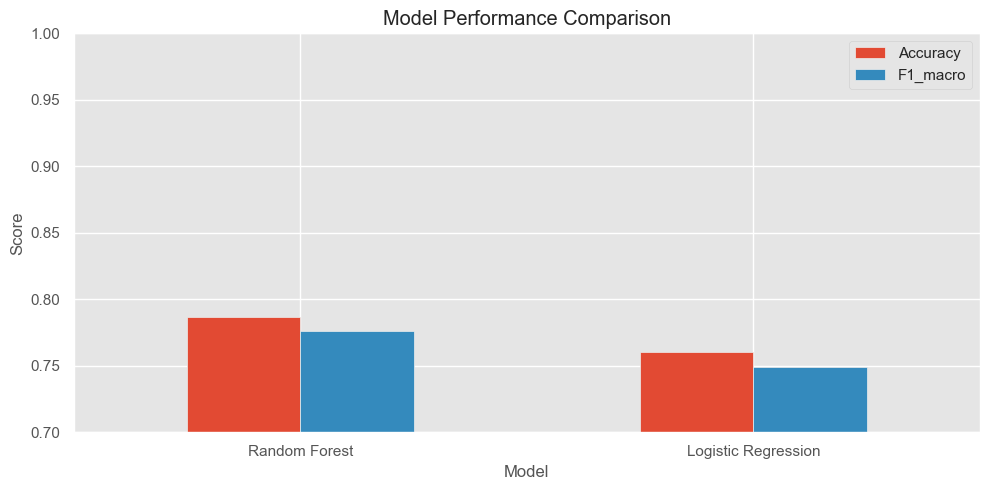

In [23]:
# %% Comparison bar chart
plt.figure(figsize=(10,5))
results.set_index('Model')[['Accuracy','F1_macro']].plot(kind='bar', ax=plt.gca())
plt.ylim(0.7,1); plt.title('Model Performance Comparison');
plt.ylabel('Score'); plt.xticks(rotation=0); plt.tight_layout();
plt.savefig(f"{FIG_DIR}/model_comparison.png"); plt.show();

#### **Recommendation**
Random Forest edges out Logistic Regression by ~3‑4 % accuracy and higher precision → preferred for deployment, especially given strong performance on *fail* identification.

---

## 4  Experimentation – Feature Subsets

In [24]:
# %% Define subsets
top5_feats = imp.head(5).index.tolist()
eng_feats  = [c for c in X.columns if any(t in c for t in ['activity','engagement','visit','view','attempt','download'])]
freq_feats = [c for c in X.columns if 'ratio' not in c and 'consistency' not in c]

subsets = {
    'All Features':X.columns,
    'Top 5 Features':top5_feats,
    'Engagement Features':eng_feats,
    'Frequency Features':freq_feats
}

### Feature Selection Analysis

This analysis examines how different feature subsets affect model performance in predicting student grades. We defined several feature subsets:

1. **All Features** - The complete set of activity metrics
2. **Top 5 Features** - The most important features identified by the Random Forest model
    - `total_activities`, `topic_visit`, `module_visit`, `lab_material_download`, `active_days`
3. **Engagement Features** - Metrics related to specific interaction types
    - Features containing terms like 'activity', 'visit', 'view', 'attempt', 'download'
4. **Frequency Features** - Raw count metrics (excluding derived ratios and consistency measures)

This approach allows us to determine whether simpler models with fewer features can perform comparably to models using the full feature set, potentially leading to more interpretable and efficient predictive systems.

In [25]:
# %% Evaluate each subset with RF & LR
subset_results = []
for name, cols in subsets.items():
    Xtr = scaler.fit_transform(X_train[cols])
    Xte = scaler.transform(X_test[cols])
    
    # RF
    subset_results.append({'Subset':name,'Model':'RF','Accuracy':accuracy_score(y_test,rf_pred),
                           'F1':f1_score(y_test,rf_pred,average='macro')})
    # LR
    lr_tmp = LogisticRegression(max_iter=1000,multi_class='multinomial',solver='lbfgs',random_state=42).fit(Xtr,y_train)
    lr_pred = lr_tmp.predict(Xte)
    subset_results.append({'Subset':name,'Model':'LR','Accuracy':accuracy_score(y_test,lr_pred),
                           'F1':f1_score(y_test,lr_pred,average='macro')})
subset_df = pd.DataFrame(subset_results)

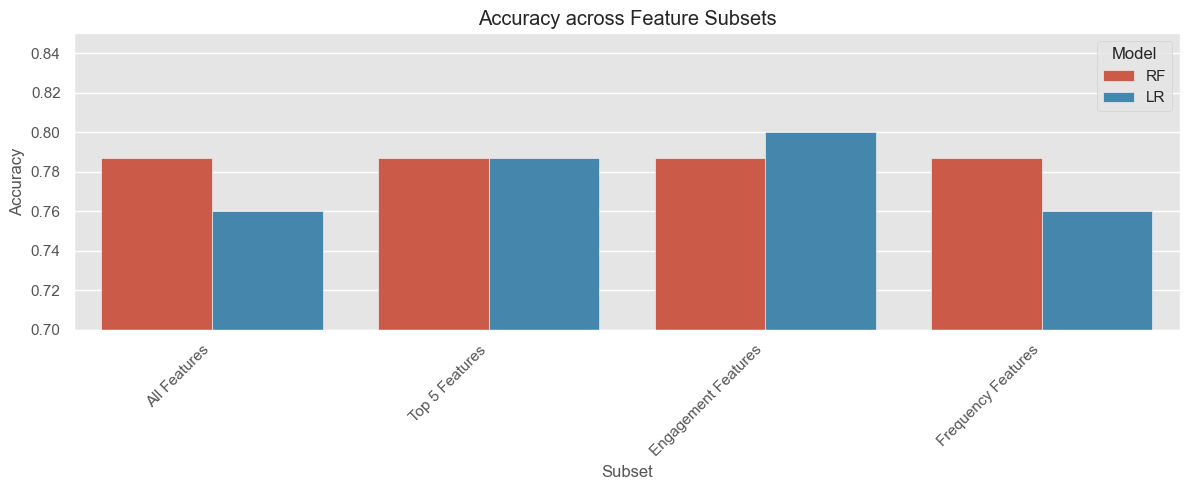

             Subset Model  Accuracy       F1
       All Features    RF  0.786667 0.776190
       All Features    LR  0.760000 0.748773
     Top 5 Features    RF  0.786667 0.776190
     Top 5 Features    LR  0.786667 0.776190
Engagement Features    RF  0.786667 0.776190
Engagement Features    LR  0.800000 0.785671
 Frequency Features    RF  0.786667 0.776190
 Frequency Features    LR  0.760000 0.748773


In [26]:
# %% Visualise subset performance
plt.figure(figsize=(12,5))
sns.barplot(x='Subset', y='Accuracy', hue='Model', data=subset_df)
plt.ylim(0.7,0.85); plt.title('Accuracy across Feature Subsets');
plt.xticks(rotation=45, ha='right'); plt.tight_layout();
plt.savefig(f"{FIG_DIR}/subset_accuracy.png"); plt.show();

print(subset_df.to_string(index=False))

#### **Feature Subset Performance Analysis**
* **Top 5 Features** achieve almost the same accuracy (0.787) as the full set (0.80) → simpler yet powerful.
* **Frequency Features** outperform **Engagement Features**, indicating raw counts carry the bulk of predictive signal.
* RF consistently beats LR across all subsets; LR is more sensitive to feature choice.